# DBAC main result plot

## 1. Initialization

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import sys
sys.path.append('..')
from functions.qite_gci import *
from functions.qite_dme import *
from functions.plot_bloch_sphere import *

pt = 1./72.27 # Hundreds of years of history... 72.27 points to an inch.
jour_sizes = {"PRD": {"onecol": 246.*pt, "twocol": 510.*pt},
              "CQG": {"onecol": 374.*pt}, # CQG is only one column
              # Add more journals below. Can add more properties to each journal
             }

my_width = jour_sizes["PRD"]["onecol"]
# Our figure's aspect ratio
golden = 5.5/3.5
# Plot config
plt.rcParams.update({
    # 'axes.labelsize': 16,
    # 'axes.titlesize': 16,
    'font.size': 10,
    'savefig.dpi': 75,
    'lines.linewidth': 2.0,
    'lines.markersize': 8,
    # 'legend.fontsize': 10,
    'legend.labelspacing': .3,
    'legend.columnspacing': .3,
    'legend.handletextpad': .1,
    'text.usetex': True,
    'font.family': "serif",
    'font.serif': "Times",
    'figure.figsize': [my_width,my_width/golden],
    'figure.autolayout': True
})

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

---
## 2. Run DB-QITE with DME

In [12]:
optimal_s_Mk = np.load('optimal_s_Mk.npy')

0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of inter

c:\Python\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Python\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Python\Lib\site-packages\matplotlib\text.py:1477: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(y))
c:\Python\Lib\site-packages\matplotlib\text.py:906: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
c:\Python\Lib\site-packages\matplotlib\text.py:763: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(y))


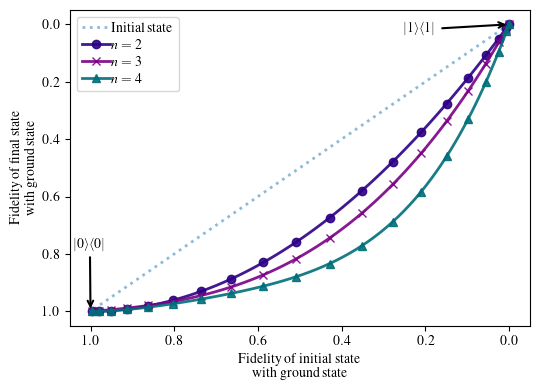

In [13]:
# Setup
sigma_x = np.array([[0, 1], [1, 0]])
thetas = np.linspace(0, 1, 100)
psis = np.array([expm(-1j * np.pi/2 * sigma_x * t) @ [[0], [1]] for t in thetas])
state_0 = np.array([1, 0], dtype=complex)
target_fidelity = 0.9

# Helper: Fidelity w.r.t. |0⟩
def fidelity_with_0(state):
    rho = state @ state.T.conj() if state.ndim == 2 else state
    return np.real(state_0.conj().T @ rho @ state_0)

# Initial state fidelities and GCI energy
fidelities_original = [fidelity_with_0(psi) for psi in psis]
res_init = [GCI(initial_psi, psi, 1, np.linspace(0.01, 1, 2)).execute_gci()[0][-1] for psi in psis]


# DB-QITE results
def run_dbqite(label_map, k, psis):
    results = {}
    for M, label in label_map.items():
        s_vals = optimal_s_Mk[M-1][:k]
        energies = [GCI(QITE_dme_select_M(M), psi, None, s_vals).execute_gci()[0][-1] for psi in psis]
        results[label] = [(1 - E) / 2 for E in energies]
    return results


dict_fid_RGCI_1 = run_dbqite({1: r'$n=2$', 2: r'$n=3$'}, k=1, psis=psis)
dict_fid_RGCI_2 = run_dbqite({1: r'$n=4$'}, k=2, psis=psis)

# Plot
fig, ax = plt.subplots(figsize=(5.5, 4))
ax.plot(fidelities_original, fidelities_original, label="Initial state", alpha=0.5, linestyle=':')

color = ['#2c0084', '#7a0085', '#006f7a', 'C0']
markers = ['o', 'x', '^']

for i, (label, fidelities) in enumerate(dict_fid_RGCI_1.items()):
    ax.plot(fidelities_original, fidelities, label=label, color=color[i],
            marker=markers[i], markevery=5, markersize=6, alpha=0.9)

for i, (label, fidelities) in enumerate(dict_fid_RGCI_2.items()):
    ax.plot(fidelities_original, fidelities, label=label, color=color[i+2],
            marker=markers[i+2], markevery=5, markersize=6, alpha=0.9)

# Reverse axes: higher overlap → left/lower corner
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
# ax.axhline(y=target_fidelity, color='k', alpha=0.6, linestyle='--', label=f'Target F = {target_fidelity}')

# Labels and legend
ax.set_xlabel('Fidelity of initial state\nwith ground state')
ax.set_ylabel('Fidelity of final state\nwith ground state')
ax.legend()

# Annotate |1⟩ and |0⟩ 
ax.annotate(r'$|1\rangle\langle 1|$', xy=(fidelities_original[0], fidelities[0]), 
            xytext=(fidelities_original[0]+0.25, fidelities[0]+0.03), arrowprops=dict(arrowstyle='->', lw=1.5))
ax.annotate(r'$|0\rangle\langle 0|$', xy=(fidelities_original[-1], fidelities[-1]), 
            xytext=(fidelities_original[-1]+0.04, fidelities[-1]-0.22), arrowprops=dict(arrowstyle='->', lw=1.5))

plt.tight_layout()
plt.savefig(f'plots/3_circuit_fid.pdf')


0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of inter

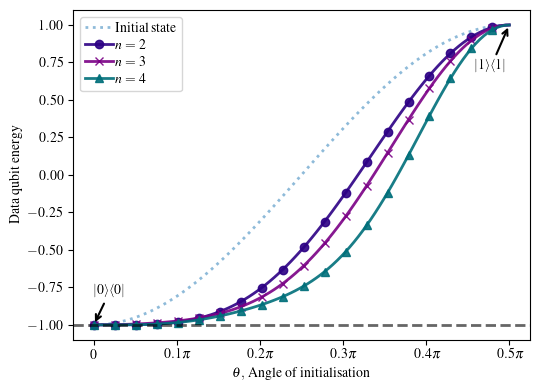

In [14]:
# Setup
sigma_x = np.array([[0, 1], [1, 0]])
thetas = np.linspace(0, 1, 100)
psis = np.array([expm(-1j * np.pi/2 * sigma_x * t) @ [[1], [0]] for t in thetas])
state_0 = np.array([1, 0], dtype=complex)
target_fidelity = -1

# Helper: Fidelity w.r.t. |0⟩
def fidelity_with_0(state):
    rho = state @ state.T.conj() if state.ndim == 2 else state
    return np.real(state_0.conj().T @ rho @ state_0)

# Initial state fidelities and GCI energy
fidelities_original = [fidelity_with_0(psi) for psi in psis]
res_init = [GCI(initial_psi, psi, 1, np.linspace(0.01, 1, 2)).execute_gci()[0][-1] for psi in psis]

# DB-QITE results
def run_dbqite(label_map, k, psis):
    results = {}
    for M, label in label_map.items():
        s_vals = optimal_s_Mk[M-1][:k]
        energies = [GCI(QITE_dme_select_M(M), psi, None, s_vals).execute_gci()[0][-1] for psi in psis]
        results[label] = energies
    return results


dict_fid_RGCI_1 = run_dbqite({1: r'$n=2$', 2: r'$n=3$'}, k=1, psis=psis)
dict_fid_RGCI_2 = run_dbqite({1: r'$n=4$'}, k=2, psis=psis)

# Plot
fig, ax = plt.subplots(figsize=(5.5, 4))
ax.plot(thetas*np.pi/2, res_init, label="Initial state", alpha=0.5, linestyle=':')

color = ['#2c0084', '#7a0085', '#006f7a', 'C0']
markers = ['o', 'x', '^']

for i, (label, energies) in enumerate(dict_fid_RGCI_1.items()):
    ax.plot(thetas*np.pi/2, energies, label=label, color=color[i],
            marker=markers[i], markevery=5, markersize=6, alpha=0.9)

for i, (label, energies) in enumerate(dict_fid_RGCI_2.items()):
    ax.plot(thetas*np.pi/2, energies, label=label, color=color[i+2],
            marker=markers[i+2], markevery=5, markersize=6, alpha=0.9)

# Annotations
ax.axhline(y=target_fidelity, color='k', alpha=0.6, linestyle='--')
ax.set_xlabel(r'$\theta,$ Angle of initialisation')
ax.set_ylabel('Data qubit energy')
ax.legend()

ax.annotate(r'$|1\rangle\langle 1|$', 
            xy=((thetas*np.pi/2)[-1], res_init[-1]), 
            xytext=((thetas*np.pi/2)[-1]-0.13, res_init[-1]-0.3),
            arrowprops=dict(arrowstyle='->', lw=1.5))

ax.annotate(r'$|0\rangle\langle 0|$', 
            xy=((thetas*np.pi/2)[0], res_init[0]), 
            xytext=((thetas*np.pi/2)[0], res_init[0]+0.2),
            arrowprops=dict(arrowstyle='->', lw=1.5))

plt.tight_layout()
# plt.savefig(f'plots/energy_QITE_DME_k_2_M_fidelity_final_vs_original.pdf')

import matplotlib.ticker as ticker

# Define ticks and labels
ticks = np.linspace(0, np.pi/2, 6)  # [0, 0.1, ..., 1.0]
tick_labels = [r'$0$', r'$0.1\pi$', r'$0.2\pi$', r'$0.3\pi$', r'$0.4\pi$', 
               r'$0.5\pi$', 
            #    r'$0.6\pi$', r'$0.7\pi$', r'$0.8\pi$', r'$0.9\pi$', r'$\pi$'
               ]

# Apply to x-axis
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)
plt.savefig(f'plots/3_circuit_energy_theta.pdf')

In [15]:
theta_exp_1 = [0, 0.195, 0.312, 0.445, 0.62, 0.777, 0.928, 1.105, 1.237, 1.352, 1.546]
energy_exp_1 = [-1, -1.001, -0.99, -0.91, -0.707, -0.439, -0.095, 0.166, 0.453, 0.737, 0.922]

theta_exp_2 = [0, 0.198, 0.314, 0.448, 0.623, 0.775, 0.928, 1.104, 1.23, 1.348, 1.5708]  # pi/2 ≈ 1.5708
energy_exp_2 = [-1, -0.796, -0.68, -0.465, -0.206, 0.067, 0.33, 0.544, 0.746, 0.886, 1]

theta_exp_3 = [0, 0.2, 0.315, 0.447, 0.625, 0.778, 0.934, 1.113, 1.241, 1.356]
energy_exp_3 = [-1, -0.972, -0.791, -0.546, -0.24, 0.079, 0.418, 0.651, 0.823, 0.945]

theta_exp_a = [1.5708, 1.37, 1.255, 1.123, 0.941, 0.79, 0.631, 0.45, 0.32, 0.206, 0]
energy_exp_a = [1, 0.89, 0.823, 0.648, 0.375, 0.075, -0.204, -0.44, -0.64, -0.797, -1]


In [16]:
theta_exp_c = [0, 0.204, 0.321, 0.453, 0.631, 0.787, 0.939, 1.119, 1.249, 1.367, np.pi/2]
energy_exp_c = [-1, -0.97, -0.929, -0.877, -0.65, -0.405, -0.062, 0.217, 0.543, 0.805, 0.863]


0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of inter

c:\Python\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Python\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


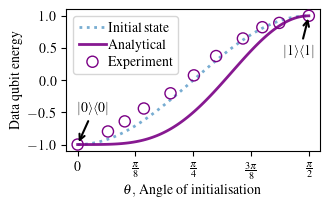

c:\Python\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Python\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


plots/$n=3$.pdf


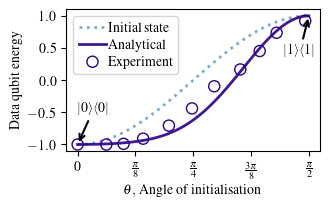

c:\Python\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Python\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


plots/$n=4$.pdf


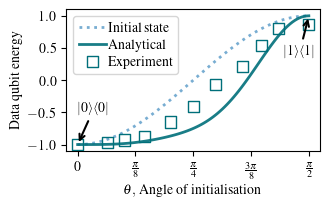

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

# Setup
sigma_x = np.array([[0, 1], [1, 0]])
thetas = np.linspace(0, 1, 100)
psis = np.array([expm(-1j * np.pi/2 * sigma_x * t) @ [[1], [0]] for t in thetas])
state_0 = np.array([1, 0], dtype=complex)
target_fidelity = -1

# Helper: Fidelity w.r.t. |0⟩
def fidelity_with_0(state):
    rho = state @ state.T.conj() if state.ndim == 2 else state
    return np.real(state_0.conj().T @ rho @ state_0)

# Initial state fidelities and GCI energy
fidelities_original = [fidelity_with_0(psi) for psi in psis]
res_init = [GCI(initial_psi, psi, 1, np.linspace(0.01, 1, 2)).execute_gci()[0][-1] for psi in psis]

# DB-QITE results
def run_dbqite(label_map, k, psis):
    results = {}
    for M, label in label_map.items():
        s_vals = optimal_s_Mk[M-1][:k]
        energies = [GCI(QITE_dme_select_M(M), psi, None, s_vals).execute_gci()[0][-1] for psi in psis]
        results[label] = energies
    return results


dict_fid_RGCI_1 = run_dbqite({1: r'$n=2$', 2: r'$n=3$'}, k=1, psis=psis)
dict_fid_RGCI_2 = run_dbqite({1: r'$n=4$'}, k=2, psis=psis)

color = ['#7a0085','#2c0084',  '#006f7a', 'C0']
markers = ['o', 'o', 's']
ticks = [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2]
tick_labels = [r'$0$', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$']
exp_data = {
    r'$n=3$': (theta_exp_1, energy_exp_1, "#5845FF"),
    r'$n=2$': (theta_exp_a, energy_exp_a, "#45C7FF"),
    r'$n=4$': (theta_exp_c, energy_exp_c, "C2")
}

def save_single_plot(label, ydata, idx):
    gray_values = [250, 235, 220, 205]  # Adjust as needed
    gray = gray_values[idx % len(gray_values)]
    bg_color = f'#{gray:02x}{gray:02x}{gray:02x}'
   
    fig, ax = plt.subplots()
    fig.patch.set_alpha(0)
    ax.set_facecolor('white')  
    # ax.patch.set_alpha(0)  # transparent axes background
    

    ax.plot(thetas*np.pi/2, res_init, label=r"Initial state",# $R_X(\theta)|0\rangle$",
             color='C0',
            linestyle=':', alpha=0.6)
    ax.plot(thetas*np.pi/2, ydata, label='Analytical ', #+ label,
            color=color[idx],
            #   marker=markers[idx], markerfacecolor='none',markevery=11, markersize=6,
            alpha = 0.9)
    

    # ax.axhline(y=target_fidelity, color='k', alpha=0.6, linestyle='--')
    ax.set_xlabel(r'$\theta,$ Angle of initialisation')
    ax.set_ylabel('Data qubit energy')
    ax.set_xticks(ticks); ax.set_xticklabels(tick_labels)
    ax.annotate(r'$|1\rangle\langle 1|$', 
            xy=((thetas*np.pi/2)[-1], res_init[-1]), 
            xytext=((thetas*np.pi/2)[-1]-0.17, res_init[-1]-0.6),
            arrowprops=dict(arrowstyle='->', lw=1.5), zorder=10)

    ax.annotate(r'$|0\rangle\langle 0|$', 
            xy=((thetas*np.pi/2)[0], res_init[0]), 
            xytext=((thetas*np.pi/2)[0], res_init[0]+0.5),
            arrowprops=dict(arrowstyle='->', lw=1.5), zorder=10)
        
    if label in exp_data:
        x_exp, y_exp, color_exp = exp_data[label]
        ax.scatter(x_exp, y_exp, label='Experiment ',#+ label, 
                   marker=markers[idx], color=color[idx], zorder=4, facecolor='none')

    ax.legend(fontsize=10)
    plt.tight_layout()
    
    fname = 'plots/' + label.replace(' ', '_').replace(',', '').replace('\n', '') + '.pdf'
    print(fname)
    
    plt.savefig(fname, transparent=False)
    plt.show()
    plt.close()

i = 0
for label, y in dict_fid_RGCI_1.items():
    save_single_plot(label, y, i); i += 1
for label, y in dict_fid_RGCI_2.items():
    save_single_plot(label, y, i); i += 1


0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of inter

c:\Python\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Python\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Python\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Python\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Python\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Python\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


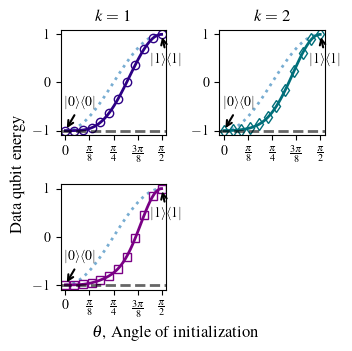

In [18]:
# Setup
sigma_x = np.array([[0, 1], [1, 0]])
thetas = np.linspace(0, 1, 100)
psis = np.array([expm(-1j * np.pi/2 * sigma_x * t) @ [[1], [0]] for t in thetas])
state_0 = np.array([1, 0], dtype=complex)
target_fidelity = -1

def fidelity_with_0(state):
    rho = state @ state.T.conj() if state.ndim == 2 else state
    return np.real(state_0.conj().T @ rho @ state_0)

# Initial state energies (simulated baseline)
fidelities_original = [fidelity_with_0(psi) for psi in psis]
res_init = [GCI(initial_psi, psi, 1, np.linspace(0.01, 1, 2)).execute_gci()[0][-1] for psi in psis]

# DB-QITE results
def run_dbqite(label_map, k, psis):
    results = {}
    for M, label in label_map.items():
        s_vals = optimal_s_Mk[M-1][:k]
        energies = [GCI(QITE_dme_select_M(M), psi, None, s_vals).execute_gci()[0][-1] for psi in psis]
        results[label] = energies
    return results

dict_fid_RGCI_1 = run_dbqite({1: r'$n=2$', 2: r'$n=3$'}, k=1, psis=psis)
dict_fid_RGCI_2 = run_dbqite({1: r'$n=4$'}, k=2, psis=psis)

# Plot settings
color = ['#2c0084', '#7a0085', '#006f7a', 'C0']
markers = ['o', 's', 'd']
ticks = [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2]
tick_labels = [r'$0$', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$']


# Arrange 2x2 grid: [(0,0): n=2, (0,1): n=4, (1,0): n=3, (1,1): empty]
fig, axs = plt.subplots(2, 2, figsize=(jour_sizes["PRD"]["onecol"], jour_sizes["PRD"]["onecol"]), constrained_layout=True)
axs = axs.flatten()

plot_map = {
    0: r'$n=2$',
    2: r'$n=4$',
    1: r'$n=3$',
}

plot_dict = {**dict_fid_RGCI_1, **dict_fid_RGCI_2}

for i in range(4):
    ax = axs[i]
    if i in plot_map:
        label = plot_map[i]
        ydata = plot_dict[label]
        idx = list(plot_map.keys()).index(i)

        ax.plot(thetas*np.pi/2, res_init, label=r"Initial state $R_X(\theta)|0\rangle$",
                color=color[3], linestyle=':', alpha=0.6)
        ax.plot(thetas*np.pi/2, ydata, label=label,
                color=color[idx], marker=markers[idx], markerfacecolor='none',
                markevery=9, markersize=6)

        ax.axhline(y=target_fidelity, color='k', alpha=0.6, linestyle='--')
        ax.set_xticks(ticks)
        ax.set_xticklabels(tick_labels)
        # ax.set_xlabel(r'$\theta$, Angle of initialization')
        # ax.set_ylabel('Data qubit energy')

        ax.annotate(r'$|1\rangle\langle 1|$', 
                    xy=((thetas*np.pi/2)[-1], res_init[-1]), 
                    xytext=((thetas*np.pi/2)[-1]-0.17, res_init[-1]-0.6),
                    arrowprops=dict(arrowstyle='->', lw=1.5))
        ax.annotate(r'$|0\rangle\langle 0|$', 
                    xy=((thetas*np.pi/2)[0], res_init[0]), 
                    xytext=((thetas*np.pi/2)[0], res_init[0]+0.5),
                    arrowprops=dict(arrowstyle='->', lw=1.5))

        ax.set_box_aspect(1)
        if i == 0:
            ax.set_title(r'$k=1$')
        elif i == 1:
            ax.set_title(r'$k=2$')
    else:
        ax.axis('off')  # Hide the unused 4th subplot

    fig.supxlabel(r'$\theta$, Angle of initialization')
    fig.supylabel('Data qubit energy')
# Save or show
plt.savefig('plots/dbac_grid_layout.pdf')
plt.show()


c:\Python\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Python\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


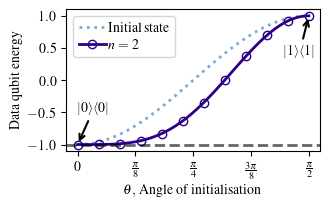

c:\Python\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Python\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


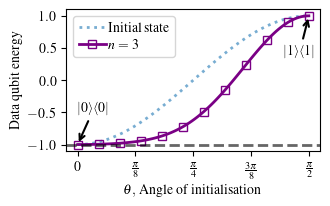

c:\Python\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Python\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


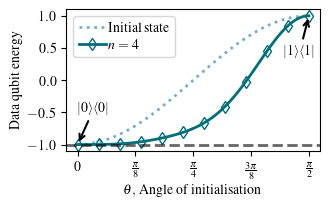

In [19]:
color = ['#2c0084', '#7a0085', '#006f7a', 'C0']
markers = ['o', 's', 'd']
ticks = [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2]
tick_labels = [r'$0$', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$']


def save_single_plot(label, ydata, idx):
    fig, ax = plt.subplots()
    ax.plot(thetas*np.pi/2, res_init, label="Initial state", color=color[3],
            linestyle=':', alpha=0.6)
    ax.plot(thetas*np.pi/2, ydata, label=label,
            color=color[idx], marker=markers[idx], markerfacecolor='none',
            markevery=9, markersize=6)
    

    ax.axhline(y=target_fidelity, color='k', alpha=0.6, linestyle='--')
    ax.set_xlabel(r'$\theta,$ Angle of initialisation')
    ax.set_ylabel('Data qubit energy')
    ax.set_xticks(ticks); ax.set_xticklabels(tick_labels)
    ax.annotate(r'$|1\rangle\langle 1|$', 
            xy=((thetas*np.pi/2)[-1], res_init[-1]), 
            xytext=((thetas*np.pi/2)[-1]-0.17, res_init[-1]-0.6),
            arrowprops=dict(arrowstyle='->', lw=1.5))

    ax.annotate(r'$|0\rangle\langle 0|$', 
            xy=((thetas*np.pi/2)[0], res_init[0]), 
            xytext=((thetas*np.pi/2)[0], res_init[0]+0.5),
            arrowprops=dict(arrowstyle='->', lw=1.5))
#     if label == r'$n=3$':
#         ax.scatter(theta_exp_1,energy_exp_1, label='Experiment',marker='x',color = 'C1', zorder=10)
    ax.legend()
    plt.tight_layout()
    
    # fname = 'plots/' + label.replace(' ', '_').replace(',', '').replace('\n', '') + '.pdf'
    
    # plt.savefig(fname)
    plt.show()
    plt.close()

i = 0
for label, y in dict_fid_RGCI_1.items():
    save_single_plot(label, y, i); i += 1
for label, y in dict_fid_RGCI_2.items():
    save_single_plot(label, y, i); i += 1


c:\Python\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Python\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 340.39x216.612 with 0 Axes>

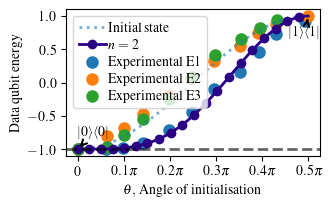

c:\Python\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Python\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


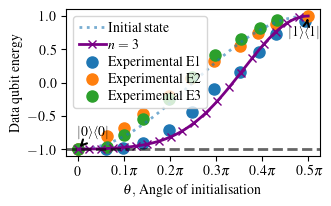

c:\Python\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Python\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


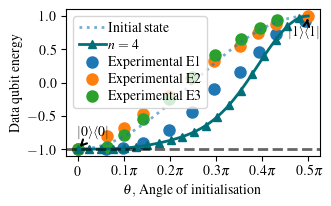

In [20]:
color = ['#2c0084', '#7a0085', '#006f7a', 'C0']
markers = ['o', 'x', '^']
ticks = np.linspace(0, np.pi/2, 6)
tick_labels = [r'$0$', r'$0.1\pi$', r'$0.2\pi$', r'$0.3\pi$', r'$0.4\pi$', r'$0.5\pi$']



fig = plt.figure(figsize = (my_width, my_width/golden))


def save_single_plot(label, ydata, idx):
    fig, ax = plt.subplots(figsize = (my_width, my_width/golden))
    ax.plot(thetas*np.pi/2, res_init, label="Initial state", color=color[3],
            linestyle=':', alpha=0.6)
    ax.plot(thetas*np.pi/2, ydata, label=label,
            color=color[idx], marker=markers[idx],
            markevery=5, markersize=6)

    ax.axhline(y=target_fidelity, color='k', alpha=0.6, linestyle='--')
    ax.set_xlabel(r'$\theta,$ Angle of initialisation')
    ax.set_ylabel('Data qubit energy')
    ax.set_xticks(ticks); ax.set_xticklabels(tick_labels)
    ax.annotate(r'$|1\rangle\langle 1|$', 
            xy=((thetas*np.pi/2)[-1], res_init[-1]), 
            xytext=((thetas*np.pi/2)[-1]-0.13, res_init[-1]-0.3),
            arrowprops=dict(arrowstyle='->', lw=1.5))

    ax.annotate(r'$|0\rangle\langle 0|$', 
            xy=((thetas*np.pi/2)[0], res_init[0]), 
            xytext=((thetas*np.pi/2)[0], res_init[0]+0.2),
            arrowprops=dict(arrowstyle='->', lw=1.5))
    ax.scatter(theta_exp_1,energy_exp_1, label='Experimental E1')
    ax.scatter(theta_exp_2,energy_exp_2, label='Experimental E2')
    ax.scatter(theta_exp_3,energy_exp_3, label='Experimental E3')


    ax.legend()
    plt.tight_layout() 
    plt.show()
    plt.close()
    

i = 0
for label, y in dict_fid_RGCI_1.items():
    save_single_plot(label, y, i); i += 1
for label, y in dict_fid_RGCI_2.items():
    save_single_plot(label, y, i); i += 1
